In [ ]:
!pip install open3d scipy matplotlib

# Imports
import open3d as o3d
import numpy as np
from scipy.spatial import cKDTree
from time import perf_counter
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
#load clouds
P_cloud = o3d.io.read_point_cloud('scene1_perspective1.ply') #Source P
Q_cloud = o3d.io.read_point_cloud('scene1_perspective2.ply') #Target Q
P = np.asarray(P_cloud.points,dtype=np.float64)
Q = np.asarray(Q_cloud.points,dtype=np.float64)

In [ ]:
# Voxel downsampling (this is different than index downsampling)

def voxel_downsample(pts, voxel = 2.0):
  if len(pts) == 0:
    return pts
  selected = np.floor(pts/voxel).astype(np.int64)
  _,idx = np.unique(selected,axis=0,return_index=True)
  return pts[np.sort(idx)]

P = voxel_downsample(P,voxel = 2.0)
Q = voxel_downsample(Q,voxel = 2.0)


In [ ]:
# Zero-mean centering

P = P - np.mean(P,axis=0)
Q = Q - np.mean(Q,axis=0)


In [ ]:
# Algorithm's transform function to obtain R and t
def best_rigid_transform(A,B):
  # Given A and B, this returns rotation R(3x3) and translation t (3,1)

  Ac = A - np.mean(A,axis=0)
  Bc = B - np.mean(B,axis=0)
  H = Ac.T @ Bc
  U,S,Vt = np.linalg.svd(H)
  R = Vt.T @ U.T
  if np.linalg.det(R) < 0:
    Vt[2,:] *= -1
    R = Vt.T @ U.T

  t = B.mean(axis=0) - R @ A.mean(axis=0)
  return R,t


In [ ]:
# ICP function

def icp_point2point(P_full,Q_full,max_iters = 60,tol = 1e-6,reject_percentile = 90):

  X = P_full.copy()
  tree = cKDTree(Q_full)
  prev_error = np.inf
  rmse_hist = []
  T_full = np.eye(4)
  t0 = perf_counter()

  for it in range(max_iters):

    #Correspondances

    dists,idx = tree.query(X,k=1)
    A_full = X
    B_full = Q_full[idx]

    # drop outliers

    thr = np.percentile(dists,reject_percentile)
    mask = dists < thr
    A = A_full[mask]
    B = B_full[mask]

    R,t = best_rigid_transform(A,B)

    X = (R @ X.T).T + t
    T = np.eye(4)
    T[:3,:3] = R
    T[:3,3] = t
    T_full = T @ T_full

    rmse = np.sqrt(np.mean(np.square(dists[mask])))
    rmse_hist.append(rmse)

    if np.abs(prev_error - rmse) < tol:
      break

    prev_error = rmse

  elapsed_time = perf_counter() - t0

  return X,T_full,rmse_hist,elapsed_time, it+1





In [ ]:
P_aligned,T,rmse_hist,elapsed_time,iters = icp_point2point(P,Q,max_iters = 60,tol = 1e-6,reject_percentile = 90)



ICP done: 60 iters | RMSE = 3.1254769548704986 | Time =  99.34628019000002s
Transform: [[ 7.67501191e-01 -2.55264287e-02 -6.40539089e-01 -1.62128470e+01]
 [ 2.52584973e-02  9.99635127e-01 -9.57191863e-03 -1.68826856e+01]
 [ 6.40549710e-01 -8.83259591e-03  7.67865909e-01 -8.85347024e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


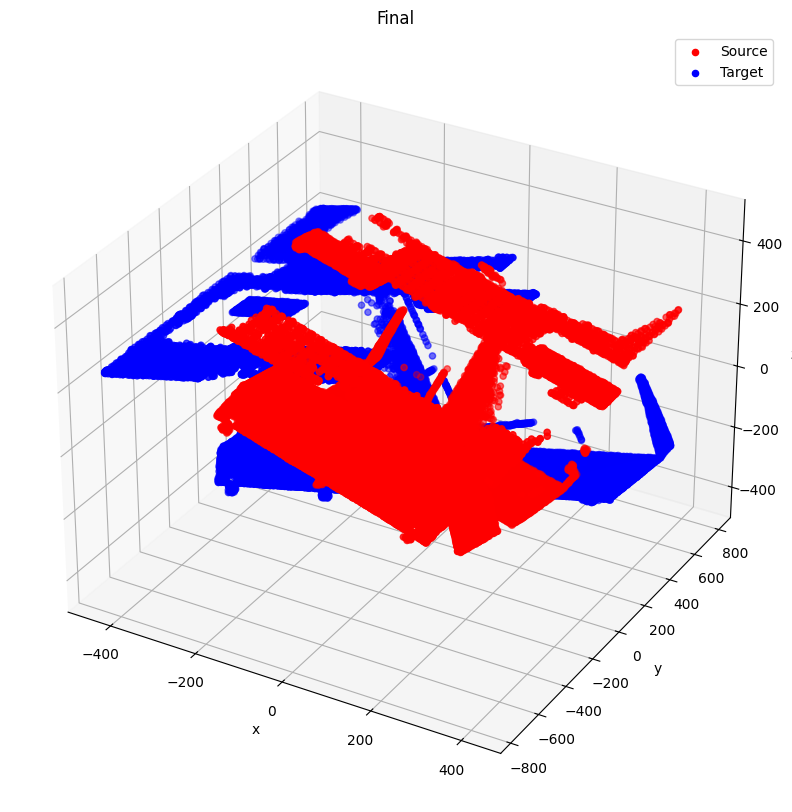

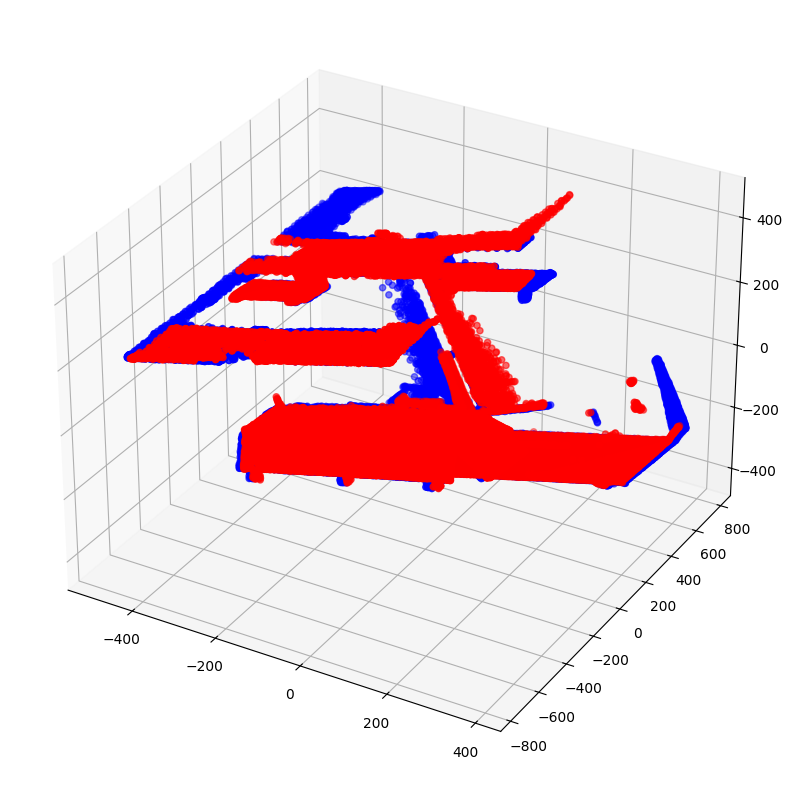

In [ ]:
#Outputs

print(f"ICP done: {iters} iters | RMSE = {rmse_hist[-1]:} | Time = {elapsed_time: }s")
print('Transform:', T)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(P[::5,0],P[::5,1],P[::5,2],c='r',label='Source')
ax.scatter(Q[::5,0],Q[::5,1],Q[::5,2],c='b',label='Target')
ax.set_title('Initial'); ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z'); ax.legend()


fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(projection='3d')
ax2.scatter(P_aligned[::5,0],P_aligned[::5,1],P_aligned[::5,2],c='r',label='Source')
ax2.scatter(Q[::5,0],Q[::5,1],Q[::5,2],c='b',label='Target')
ax.set_title('Final'); ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z'); ax.legend()



